In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 2: Load Dataset
df = pd.read_excel("C:/Users/Masterflow techno/Downloads/Banking_Call_Data.xlsx")


In [4]:
# Step 3: Initial Data Inspection
print("Shape:", df.shape)
print(df.info())
print(df.head())

Shape: (45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
   age           job  marital  education default  balance housing loan  \
0

In [5]:
# Step 4: Drop columns 'contact' and 'poutcome' (as per problem statement)
df.drop(['contact', 'poutcome'], axis=1, inplace=True)


In [6]:
# Step 5: Check for missing values
print("Missing values:\n", df.isnull().sum())


Missing values:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64


In [7]:
# Step 6: Convert categorical columns to numeric using Label Encoding or One-Hot Encoding
# Identify categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'y']


In [8]:
# Target variable is 'y'
# Encode target variable 'y': 'yes' -> 1, 'no' -> 0
df['y'] = df['y'].map({'yes':1, 'no':0})

In [9]:
# For other categorical variables, use one-hot encoding (to avoid ordinal assumptions)
df = pd.get_dummies(df, columns=[col for col in cat_cols if col != 'y'], drop_first=True)

In [10]:
# Step 7: Outlier detection and treatment for numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('y')  # exclude target

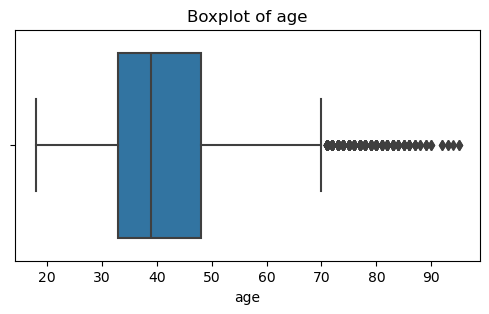

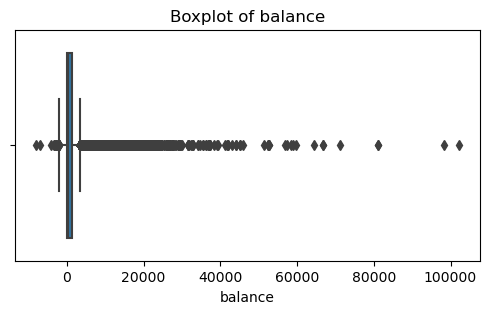

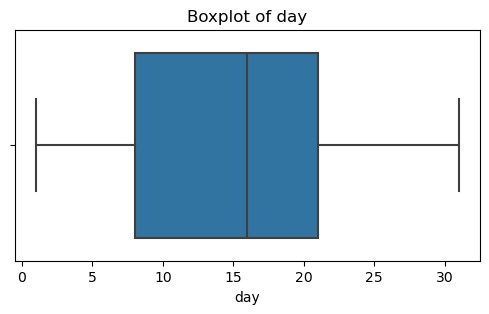

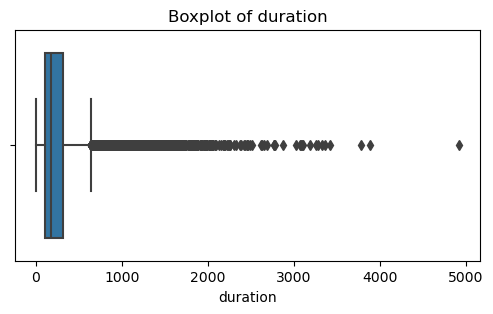

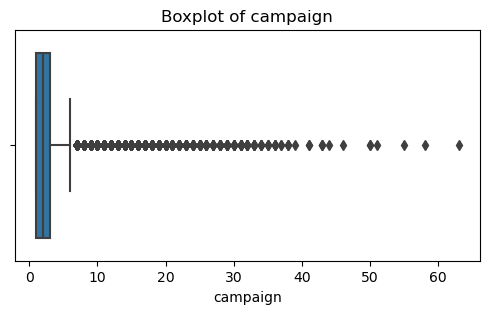

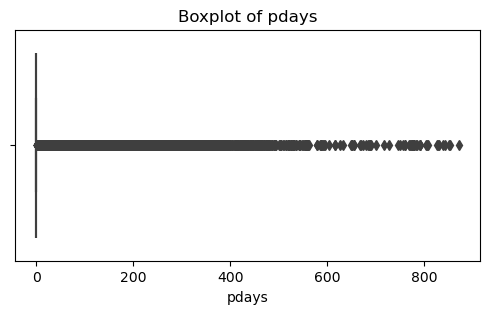

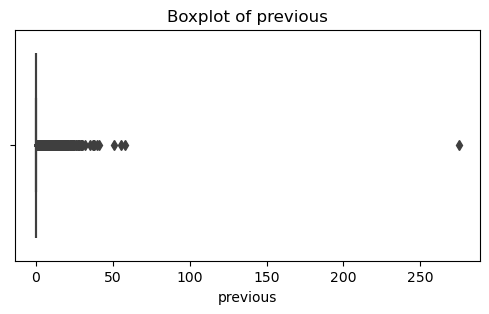

In [11]:
# Visualize boxplots for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [12]:
# Treat outliers using IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

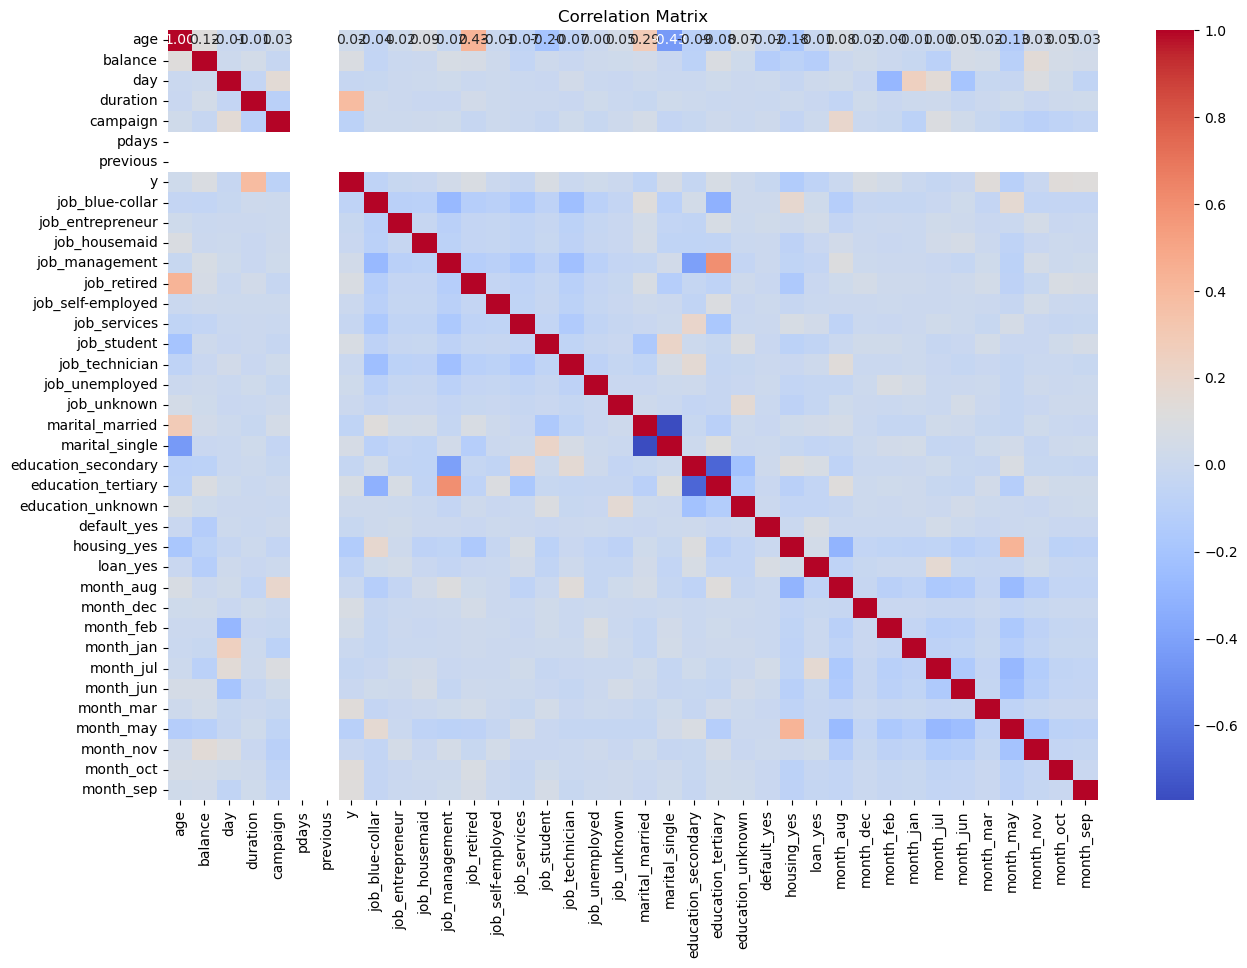

In [13]:
# Step 8: Correlation analysis to identify important features
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()


In [14]:
# Step 9: Separate features and target
X = df.drop('y', axis=1)
y = df['y']


In [15]:
# Step 10: Handle class imbalance using upsampling minority class
print("Before balancing:")
print(y.value_counts())


Before balancing:
y
0    39922
1     5289
Name: count, dtype: int64


In [16]:
# Combine X and y for resampling
df_balanced = pd.concat([X, y], axis=1)


In [17]:
# Separate majority and minority classes
df_majority = df_balanced[df_balanced.y == 0]
df_minority = df_balanced[df_balanced.y == 1]


In [18]:
# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)


In [19]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [20]:
print("After balancing:")
print(df_upsampled.y.value_counts())


After balancing:
y
0    39922
1    39922
Name: count, dtype: int64


In [21]:
# Step 11: Split into train and test sets
X_bal = df_upsampled.drop('y', axis=1)
y_bal = df_upsampled['y']


In [22]:

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)

In [23]:
# Step 12: Feature scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Step 13: Build and evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()
    
    auc = roc_auc_score(y_test, y_proba)
    print(f'ROC-AUC Score: {auc:.4f}')
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (area = {auc:.4f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.show()


              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7985
           1       0.81      0.81      0.81      7984

    accuracy                           0.81     15969
   macro avg       0.81      0.81      0.81     15969
weighted avg       0.81      0.81      0.81     15969



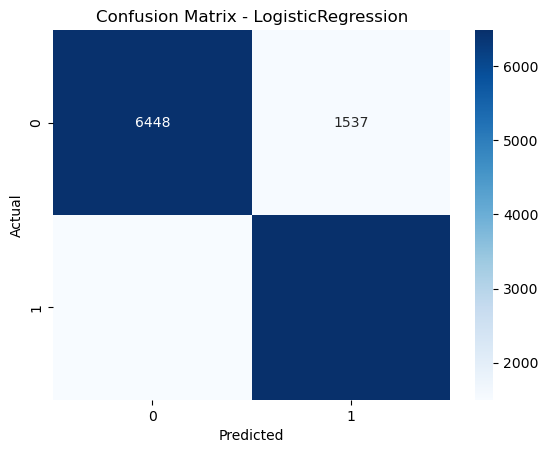

ROC-AUC Score: 0.8847


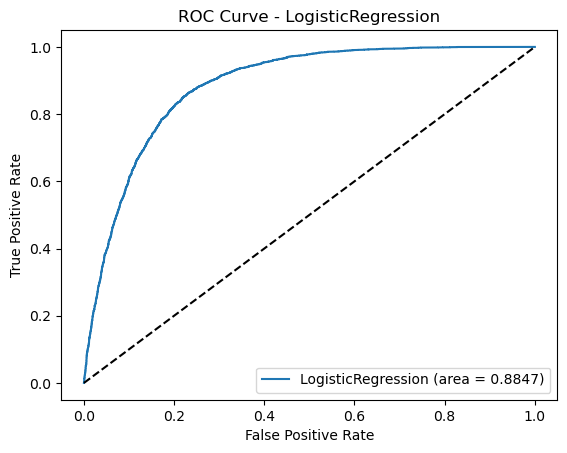

In [28]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
evaluate_model(logreg, X_test_scaled, y_test)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95      7985
           1       0.92      1.00      0.96      7984

    accuracy                           0.96     15969
   macro avg       0.96      0.96      0.96     15969
weighted avg       0.96      0.96      0.96     15969



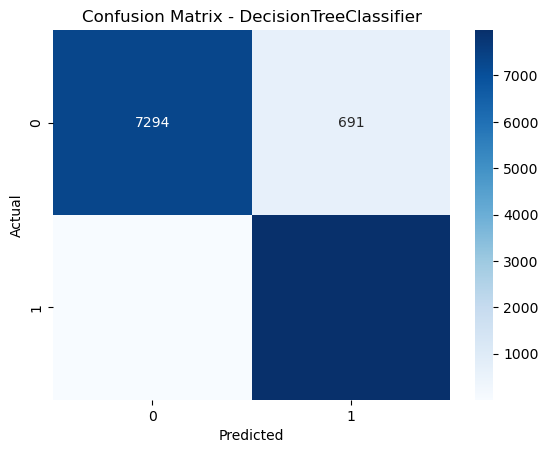

ROC-AUC Score: 0.9564


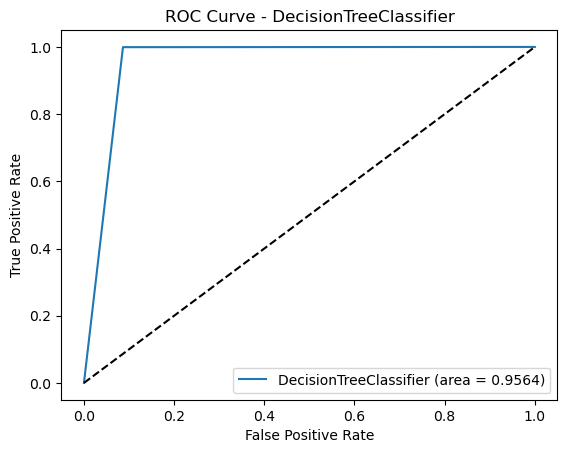

In [29]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)  # No scaling needed for tree based models
evaluate_model(dt, X_test, y_test)


              precision    recall  f1-score   support

           0       1.00      0.94      0.97      7985
           1       0.94      1.00      0.97      7984

    accuracy                           0.97     15969
   macro avg       0.97      0.97      0.97     15969
weighted avg       0.97      0.97      0.97     15969



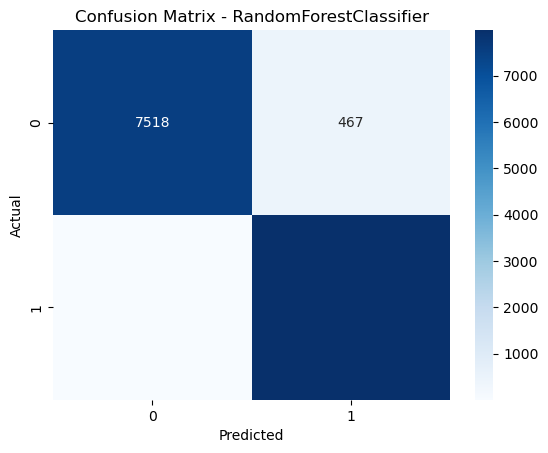

ROC-AUC Score: 0.9998


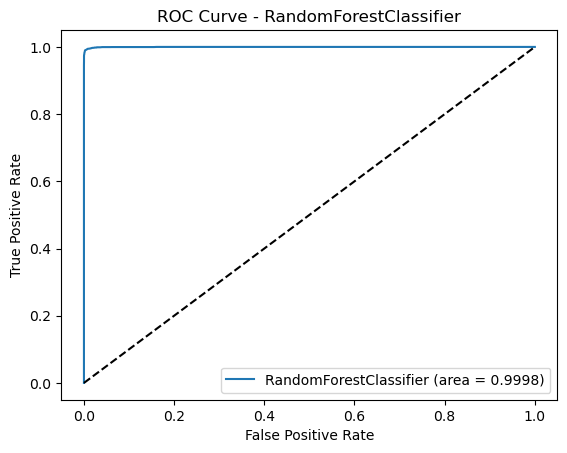

In [30]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)


              precision    recall  f1-score   support

           0       0.95      0.87      0.91      7985
           1       0.88      0.96      0.92      7984

    accuracy                           0.91     15969
   macro avg       0.92      0.91      0.91     15969
weighted avg       0.92      0.91      0.91     15969



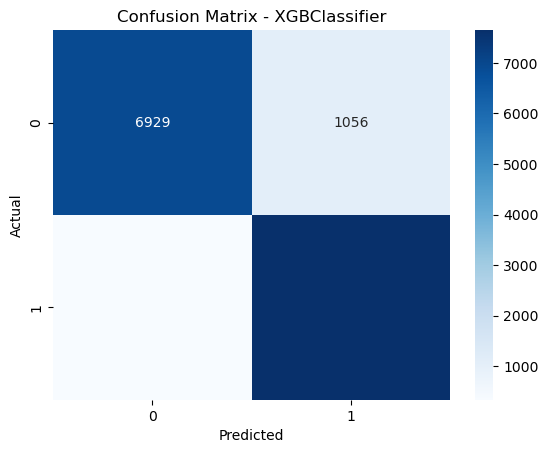

ROC-AUC Score: 0.9571


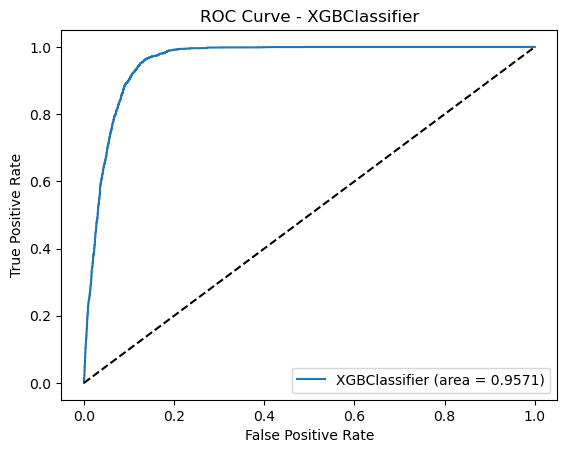

In [31]:
# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test)


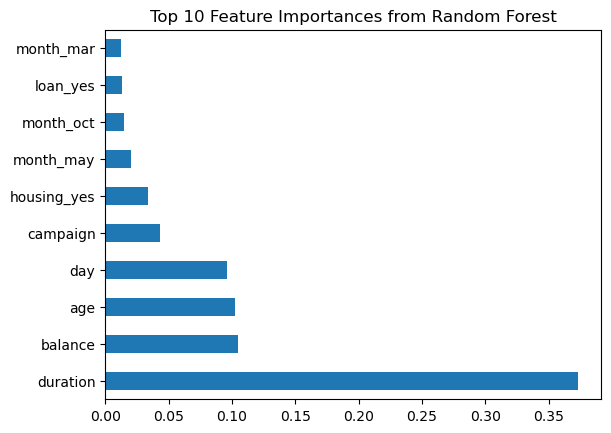

In [32]:
# Step 14: Feature importance from Random Forest
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": logreg,
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    if name == "Logistic Regression":
        X_test_input = X_test_scaled  # scaled input for logistic regression
    else:
        X_test_input = X_test         # unscaled for tree-based models
    
    y_pred = model.predict(X_test_input)
    y_proba = model.predict_proba(X_test_input)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    results.append([name, accuracy, precision, recall, f1, roc_auc])

# Create dataframe for easy visualization
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC'])
print(results_df)


                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.809694   0.808330  0.811874  0.810098  0.884740
1        Decision Tree  0.956353   0.920291  0.999248  0.958146  0.956356
2        Random Forest  0.970505   0.944714  0.999499  0.971335  0.999779
3              XGBoost  0.912894   0.878690  0.958041  0.916652  0.957112


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd

# Example data: replace these with your actual model predictions and labels
y_true = [...]        # True labels (test set)
y_pred_rf = [...]     # Predictions from Random Forest
y_proba_rf = [...]    # Predicted probabilities from Random Forest for positive class

# 1. Confusion Matrix for Random Forest
cm = confusion_matrix(y_true, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix_rf.png')
plt.show()

# 2. ROC Curve Comparison
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)

# You can add other model ROC curves here similarly

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Comparison')
plt.legend(loc="lower right")
plt.savefig('roc_curve_comparison.png')
plt.show()

# 3. Bar Chart for F1 Scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
f1_scores = [0.81, 0.96, 0.97, 0.92]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=f1_scores, palette='viridis')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0,1)
plt.savefig('f1_score_comparison.png')
plt.show()


ValueError: unknown is not supported

In [35]:
y_true = [...]        # True labels (test set)
y_pred_rf = [...]     # Predictions from Random Forest
y_proba_rf = [...]    # Predicted probabilities from Random Forest for positive class


In [36]:
y_true = [0, 1, 0, 1, 1, 0, ...]          # actual test labels
y_pred_rf = [0, 1, 0, 0, 1, 0, ...]       # predicted labels from Random Forest
y_proba_rf = [0.1, 0.9, 0.3, 0.4, 0.85, 0.2, ...]  # predicted probabilities for class 1


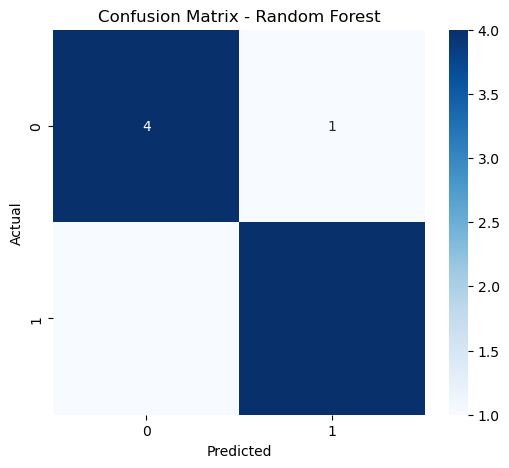

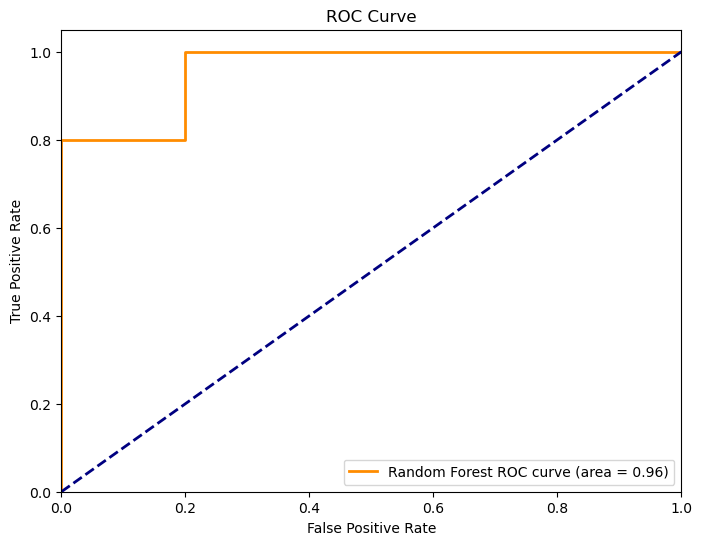

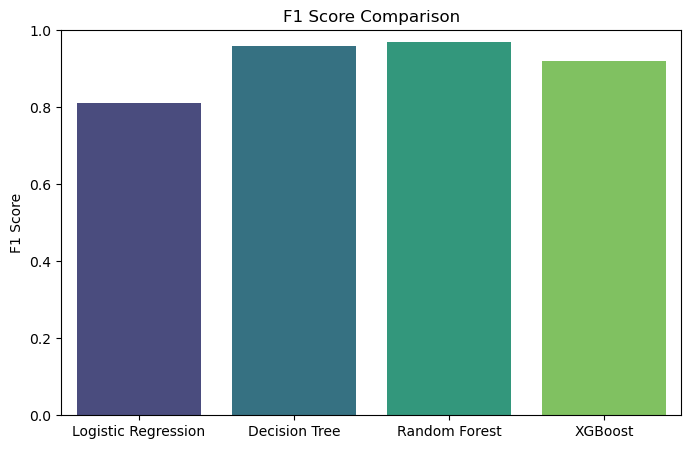

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Example synthetic data (replace these with your real results)
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
y_pred_rf = np.array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1])
y_proba_rf = np.array([0.2, 0.8, 0.3, 0.4, 0.1, 0.9, 0.05, 0.6, 0.85, 0.7])

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=2, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 3. F1 Score Bar Chart
import seaborn as sns
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
f1_scores = [0.81, 0.96, 0.97, 0.92]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=f1_scores, palette='viridis')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()
